In [1]:
! git clone https://github.com/ChenyangLEI/polarization-reflection-removal

fatal: destination path 'polarization-reflection-removal' already exists and is not an empty directory.


In [ ]:
# NO GPU
# ! pip install pytorch==2.0.0 torchvision==0.15.0 torchaudio==2.0.0

# Configured for CUDA > 11.7
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torchaudio-2.0.2%2Bcu117-cp39-cp39-win_amd64.whl (2.5 MB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ------------ --------------------------- 0.8/2.5 MB 5.6 MB/s eta 0:00:01
     --------------------- ------------------ 1.3/2.5 MB 3.2 MB/s eta 0:00:01
     ---------------------------------- ----- 2.1/2.5 MB 3.6 MB/s eta 0:00:01
     ---------------------------------------- 2.5/2.5 MB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     ----------------- ---------------------- 1.0/2.5 MB 5.0 MB/s eta 0:00:01
     ----------------------------- ---------- 1.8/2.5 MB 4.8 MB/s eta 0:00:01
     ---------------------------------------- 2.5/2.5 MB 4.5 MB/s eta 0:

Num GPUs Available: 0


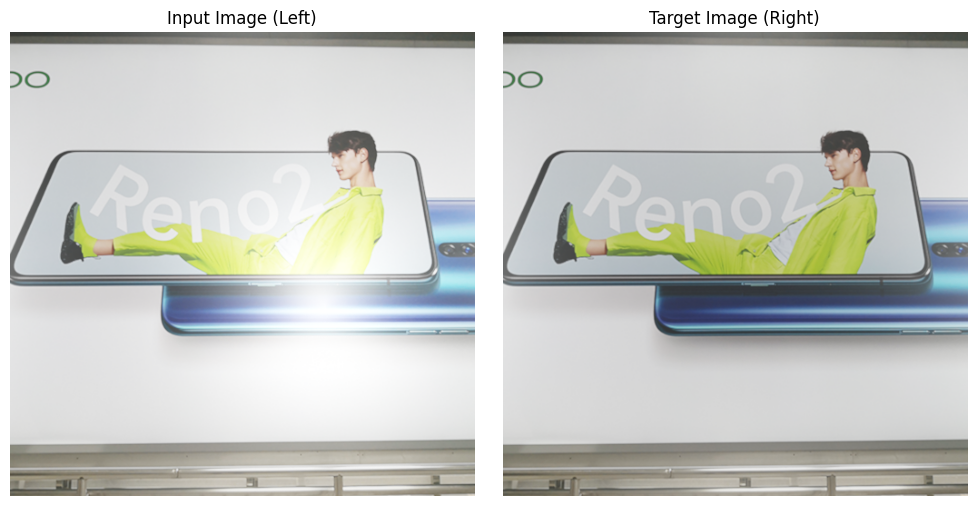

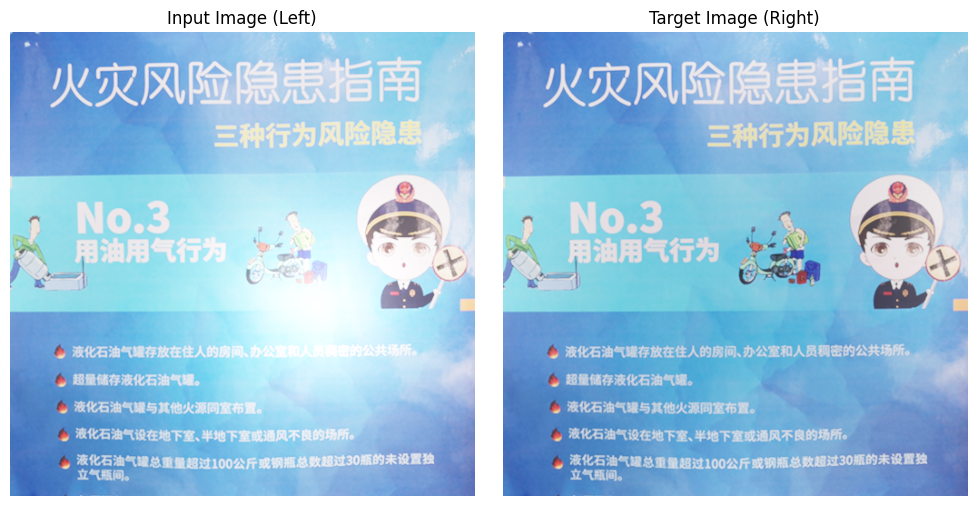

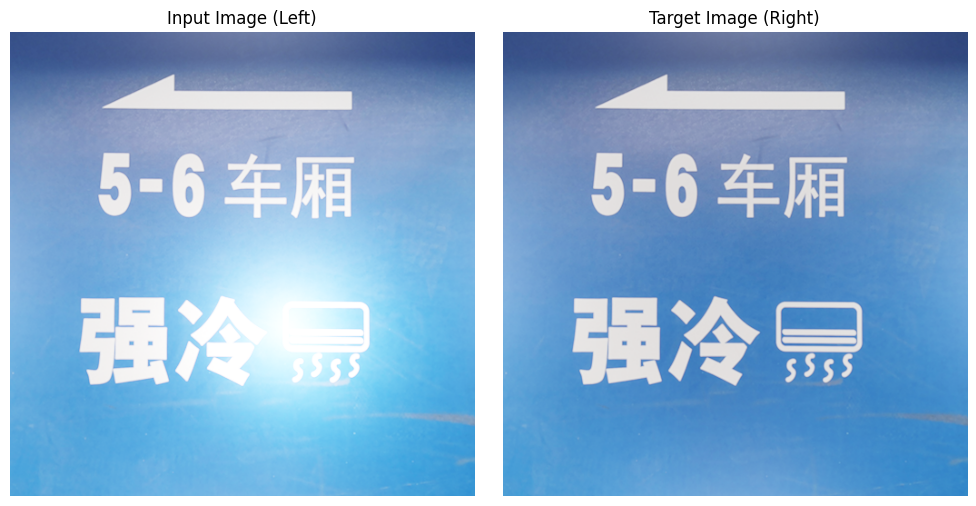

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from glob import glob
import os
from PIL import Image
from torchvision import transforms
import torch.optim as optim
# ---------------------
# Dataset
# ---------------------

class GlareRemovalDataset(Dataset):
    def __init__(self, image_dir):
        self.image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.png')]
        self.transform = transforms.ToTensor()  # Converts to [C, H, W] and scales to [0, 1]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")  # Remove alpha channel
        img = self.transform(img)  # [3, H, W], normalized

        # Split along width: [3, 512, 1024] -> input: [:, :, :512], target: [:, :, 512:]
        target_img = img[:, :, :512]
        input_img = img[:, :, 512:1024]
        
        return input_img, target_img

train_dataset = GlareRemovalDataset('SD1_Trimmed/train')
val_dataset = GlareRemovalDataset('SD1_Trimmed/val')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

# Instantiate the dataset
dataset = GlareRemovalDataset("SD1_Trimmed/train")

# Function to display a single pair
def show_sample(input_tensor, target_tensor):
    input_img = input_tensor.permute(1, 2, 0).numpy()  # [H, W, C]
    target_img = target_tensor.permute(1, 2, 0).numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(input_img)
    axes[0].set_title("Input Image (Left)")
    axes[1].imshow(target_img)
    axes[1].set_title("Target Image (Right)")
    for ax in axes:
        ax.axis("off")
    plt.tight_layout()
    plt.show()

# Show a few samples
for i in range(3):
    input_img, target_img = dataset[i]
    show_sample(input_img, target_img)
# ---------------------
# U-Net Model
# ---------------------


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dec3 = CBR(512 + 256, 256)
        self.dec2 = CBR(256 + 128, 128)
        self.dec1 = CBR(128 + 64, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        d3 = self.dec3(torch.cat([self.up(e4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], dim=1))

        out = torch.sigmoid(self.final(d1))
        return out

# ---------------------
# Training Loop
# ---------------------
model = UNet().cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

best_val_loss = float('inf')
early_stop_counter = 0

# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for epoch in range(10):
    model.train()
    total_train_loss = 0
    total_val_loss = 0

    # Training phase
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation phase
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x)
            val_loss = criterion(out, y)
            total_val_loss += val_loss.item()

    # Calculate average losses
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    
    # Store losses for plotting
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
    # Print losses for this epoch
    print(f"Epoch {epoch+1}/{10}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_unet_model.pth')  # Save the model
    else:
        early_stop_counter += 1
        if early_stop_counter >= 3:
            print("Early stopping triggered")
            break

# ------------------- Plotting the Losses -------------------
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()